In [1]:


!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 39.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5

In [2]:
  # DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
from gensim.models import Word2Vec

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
dataset_filename = 'training.1600000.processed.noemoticon.csv'
dataset_path='/content/drive/MyDrive/CFiles/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/CFiles/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 381 ms, sys: 997 µs, total: 382 ms
Wall time: 383 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

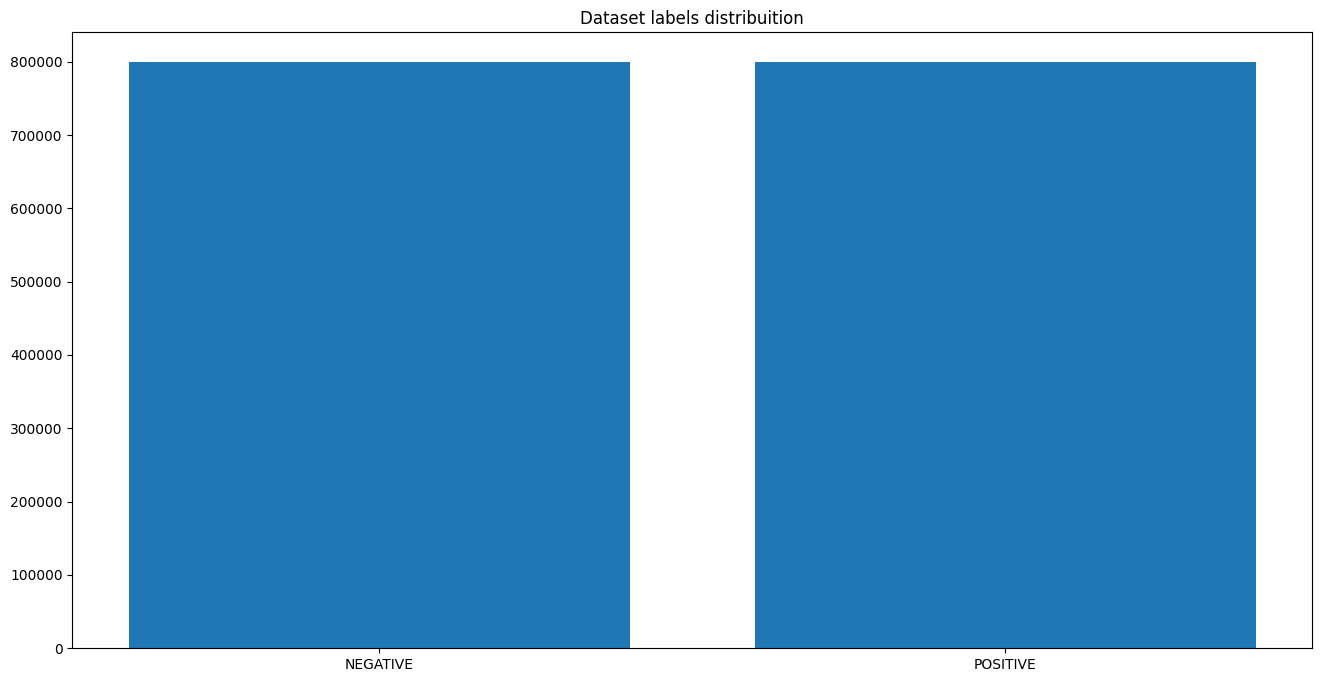

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min, sys: 270 ms, total: 1min
Wall time: 1min 2s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [15]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 3.77 s, sys: 369 ms, total: 4.14 s
Wall time: 4.23 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

In [18]:
index_to_key = w2v_model.wv.index_to_key
vocab_size = len(index_to_key)
print("Vocab size:", vocab_size)

Vocab size: 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 18min 40s, sys: 9.71 s, total: 18min 49s
Wall time: 12min 19s


(263125410, 295270528)

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 19.8 s, sys: 140 ms, total: 19.9 s
Wall time: 20.1 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.8 s, sys: 1.44 s, total: 29.2 s
Wall time: 29.6 s


In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7510

1125/1125 [==============================] - 611s 536ms/step - loss: 0.5029 - accuracy: 0.7510 - val_loss: 0.4619 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.7677

1125/1125 [==============================] - 609s 541ms/step - loss: 0.4781 - accuracy: 0.7677 - val_loss: 0.4579 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7726

1125/1125 [==============================] - 607s 539ms/step - loss: 0.4713 - accuracy: 0.7726 - val_loss: 0.4543 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7747

1125/1125 [==============================] - 604s 537ms/step - loss: 0.4678 - accuracy: 0.7747 - val_loss: 0.4511 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.7763

1125/1125 [==============================] - 606s 539ms/step - loss: 0.4648 - accuracy: 0.7763 - val_loss: 0.4502 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7774

1125/1125 [==============================] - 599s 532ms/step - loss: 0.4634 - accuracy: 0.7774 - val_loss: 0.4494 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.7785

1125/1125 [==============================] - 600s 533ms/step - loss: 0.4618 - accuracy: 0.7785 - val_loss: 0.4461 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.7791

1125/1125 [==============================] - 607s 540ms/step - loss: 0.4611 - accuracy: 0.7791 - val_loss: 0.4470 - val_accuracy: 0.7904 - lr: 0.0010
CPU times: user 1h 25min 56s, sys: 3min 11s, total: 1h 29min 7s
Wall time: 1h 21min 26s


In [31]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

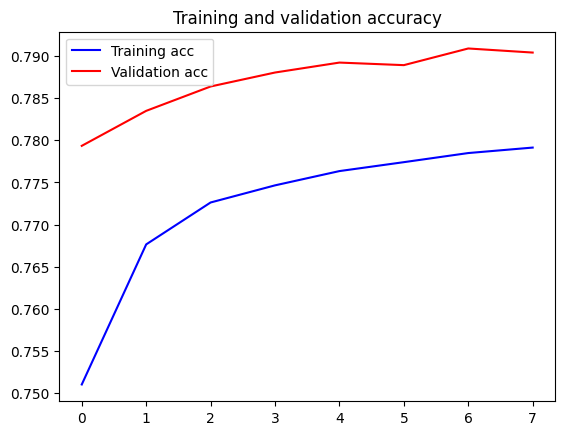

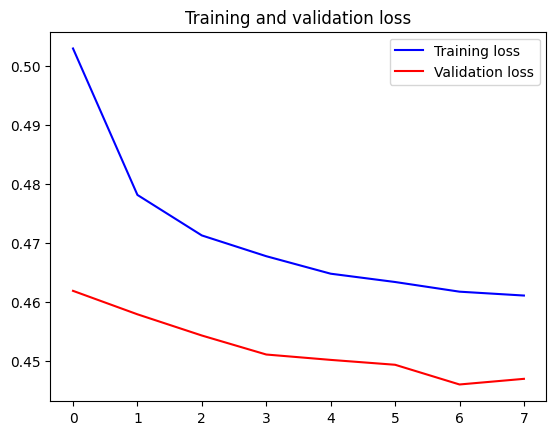

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:


def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}



In [37]:
predict("I love the music")

1/1 [==============================] - 0s 325ms/step


{'label': 'POSITIVE',
 'score': 0.9575141072273254,
 'elapsed_time': 0.37737321853637695}

In [38]:
predict("I hate the rain")

1/1 [==============================] - 0s 88ms/step


{'label': 'NEGATIVE',
 'score': 0.01085340790450573,
 'elapsed_time': 0.13350939750671387}

In [39]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 85ms/step


{'label': 'NEGATIVE',
 'score': 0.2992781400680542,
 'elapsed_time': 0.1320035457611084}

In [40]:


%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]



40/40 [==============================] - 21s 521ms/step
CPU times: user 14.9 s, sys: 8.02 s, total: 22.9 s
Wall time: 23.4 s


In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

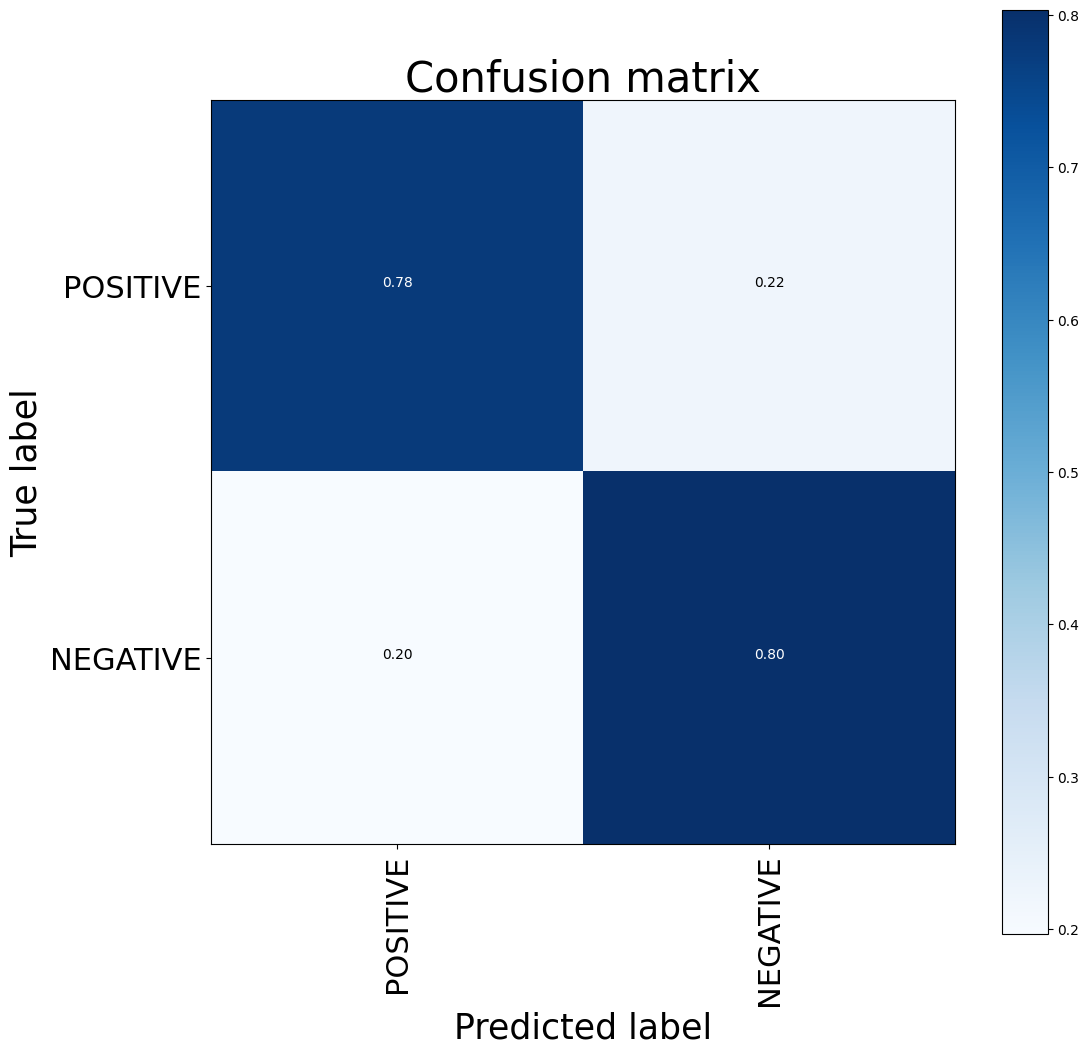

CPU times: user 1.33 s, sys: 235 ms, total: 1.56 s
Wall time: 1.34 s


In [42]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [43]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.7914

In [50]:

# Your filenames
KERAS_MODEL = "keras_model.h5"
WORD2VEC_MODEL = "word2vec_model.bin"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# Save your Keras model
model.save(KERAS_MODEL)

# Save your Word2Vec model
w2v_model.save(WORD2VEC_MODEL)

# Save the tokenizer using pickle
with open(TOKENIZER_MODEL, "wb") as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file, protocol=0)

# Save the encoder using pickle
with open(ENCODER_MODEL, "wb") as encoder_file:
    pickle.dump(encoder, encoder_file, protocol=0)

# Later, when you want to load the models and objects:

# Load the Keras model
loaded_model = tf.keras.models.load_model(KERAS_MODEL)

# Load the Word2Vec model
loaded_w2v_model = gensim.models.Word2Vec.load(WORD2VEC_MODEL)

# Load the tokenizer using pickle
with open(TOKENIZER_MODEL, "rb") as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

# Load the encoder using pickle
with open(ENCODER_MODEL, "rb") as encoder_file:
    loaded_encoder = pickle.load(encoder_file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
